# pssm.lo
> calculation of log-odds PSSM and visualization

In [ ]:
#| default_exp pssm.lo

## Overview

**Log-Odds PSSM Calculation**

To compute a log-odds Position-Specific Scoring Matrix (PSSM) by comparing observed amino acid frequencies against a background model:

```python
pssm_LO = get_pssm_LO(
    pssm_df=pssm_df,    # DataFrame of amino acid frequencies (rows=aa, cols=positions)
    site_type='STY',    # background model: 'S', 'T', 'Y', 'ST', or 'STY'
)
```

---

To compute a log-odds PSSM from a flattened (1D) frequency representation:

```python
pssm_LO = get_pssm_LO_flat(
    flat_pssm=flat_pssm,  # flattened PSSM as pd.Series
    site_type='STY',      # background model: 'S', 'T', 'Y', 'ST', or 'STY'
)
```

---

**Log-Odds Visualization**

To visualize a log-odds PSSM as a sequence logo where letter heights reflect enrichment/depletion:

```python
plot_logo_LO(
    pssm_LO=pssm_LO,        # log-odds PSSM DataFrame
    title='Motif',          # plot title
    acceptor=None,          # force display of central residue: 'S', 'T', or 'Y'
    scale_zero=True,        # rescale position 0 to match max stack height
    scale_pos_neg=True,     # normalize positive/negative stacks for visibility
    ax=None,                # matplotlib Axes (creates new if None)
    figsize=(10, 1),        # figure dimensions (width, height)
)
```

---

To display both a sequence logo and a heatmap of log-odds values in a combined figure:

```python
plot_logo_heatmap_LO(
    pssm_LO=pssm_LO,        # log-odds PSSM DataFrame
    title='Motif',          # plot title
    acceptor=None,          # force display of central residue: 'S', 'T', or 'Y'
    figsize=(17, 10),       # figure dimensions (width, height)
    include_zero=False,     # include position 0 in heatmap
    scale_pos_neg=True,     # normalize color scale for positive/negative values
)
```


## Setup

In [ ]:
#| export
import numpy as np, pandas as pd
from katlas.pssm.plot import *
from katlas.pssm.core import *
from matplotlib import pyplot as plt

In [ ]:
#| hide
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_columns', 100) # show all columns

In [ ]:
from katlas.data import *

data = Data.get_ks_dataset()
data_k = data[data.kinase_uniprot=='P49841'] # CDK1
pssm_df=get_prob(data_k, col='site_seq')

## Calculate

In [ ]:
#| export
def get_pssm_LO(pssm_df,
                site_type, # S, T, Y, ST, or STY
               ):
    "Get log odds PSSM: log2 (freq pssm/background pssm)."
    bg_pssms = Data.get_ks_background()
    flat_bg = bg_pssms.loc[f'ks_{site_type}']
    pssm_bg = recover_pssm(flat_bg)
    pssm_odds = ((pssm_df+EPSILON)/(pssm_bg+EPSILON)).dropna(axis=0,how='all').dropna(axis=1, how='all')
    # make sure all columns and index matched
    if pssm_odds.shape != pssm_df.shape: raise ValueError("Shape mismatch between PSSM and background PSSM.")
    return np.log2(pssm_odds).replace([np.inf, -np.inf], 0).fillna(0)

Let $P_i(x)$ be the frequency of amino acid $x$ at position $i$ in the input PSSM, and let $B_i(x)$ be the background frequency of amino acid $x$ at the same position, derived from a background model corresponding to the specified site type (`S`, `T`, `Y`, or `STY`).

The log-odds score at each position $i$ for amino acid $x$ is computed as:

$$
\mathrm{LO}_i(x) = \log_2 \left( \frac{P_i(x) + \varepsilon}{B_i(x) + \varepsilon} \right)
$$

where $\varepsilon = 10^{-8}$ is a small constant added for numerical stability and to avoid division by zero.

This results in a matrix where:

- Positive values indicate enrichment over background,
- Negative values indicate depletion relative to background,
- Zero indicates no difference from the expected background.

In [ ]:
pssm_LO = get_pssm_LO(pssm_df,'STY')
pssm_LO.head()

Position,-20,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
aa,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
P,0.059908,0.281140,-0.026749,0.355318,0.346468,0.178779,0.463147,0.308758,0.239997,0.179283,0.608034,0.192985,0.329370,0.721201,0.715760,0.588674,0.320993,1.112040,0.973481,1.055403,0.0,1.539081,1.109428,0.434700,-0.301588,1.379883,0.314032,0.243357,-0.060158,0.644231,0.061865,0.161917,0.308782,0.140834,0.521194,0.373708,0.158627,0.462854,0.138734,0.658643,0.216764
G,0.355425,0.331928,0.015762,-0.090070,0.155057,-0.318908,0.274539,0.486357,-0.081333,-0.044640,-0.023817,0.297183,-0.167014,-0.096944,-0.092276,-0.064319,-0.075365,0.473975,0.243292,0.358158,0.0,0.235499,-0.025131,0.284594,-0.457652,-0.327199,-0.123033,0.303309,0.315783,-0.190655,-0.067465,0.298568,0.361469,0.170286,0.215167,0.258789,-0.054255,-0.185829,0.200256,0.388134,-0.066157
A,0.445724,0.399204,0.032468,0.105841,0.037853,0.527832,0.039466,-0.201953,0.117073,0.243623,0.053728,-0.015571,0.335906,0.169137,-0.130969,-0.098714,-0.444541,0.119458,0.286568,0.060413,0.0,-0.584316,0.490663,-0.075931,-0.078570,0.109301,0.496097,0.191241,-0.008452,-0.306504,0.241955,-0.675462,-0.013856,0.172464,-0.080489,-0.019176,0.360468,0.315254,0.109869,-0.375457,0.164260
C,0.537945,-0.956246,-0.269417,-0.055141,-0.547438,-0.718577,-0.987818,0.075745,0.419542,-0.634510,-0.603081,-0.233384,0.494481,0.142392,0.851304,0.003453,-0.677106,-0.935493,0.789298,0.156753,0.0,-0.937435,0.945576,0.925658,-1.573420,-1.149739,0.860460,-0.169595,-0.143715,0.200914,-0.385030,0.235879,0.725572,-0.115854,0.491228,-0.070391,-0.647993,-0.426118,1.057556,-1.543537,-0.898042
S,0.482063,0.128128,0.452159,-0.214803,0.139830,0.049341,0.317830,-0.214082,0.175540,-0.036560,0.017835,0.187378,0.362312,-0.239848,0.014115,0.612648,-0.070659,-0.737274,0.126846,0.744032,0.0,-0.314505,0.076891,0.803635,0.224781,-0.198496,0.474760,0.303879,0.367185,-0.142147,0.492529,0.309106,-0.086104,-0.016800,-0.160346,-0.145271,-0.167390,-0.262078,0.101268,0.189145,0.426381


In [ ]:
#| export
def get_pssm_LO_flat(flat_pssm,
                    site_type, # S, T, Y, ST, or STY
                    ):
    pssm_df = recover_pssm(flat_pssm)
    return get_pssm_LO(pssm_df,site_type)

In [ ]:
flat_pssm=pd.Series(flatten_pssm(pssm_df))

In [ ]:
pssm_LO = get_pssm_LO_flat(flat_pssm,'STY')
pssm_LO

Position,-20,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
aa,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
P,0.059908,0.281140,-0.026749,0.355318,0.346468,0.178779,0.463147,0.308758,0.239997,0.179283,0.608034,0.192985,0.329370,0.721201,0.715760,0.588674,0.320993,1.112040,0.973481,1.055403,0.000000,1.539081,1.109428,0.434700,-0.301588,1.379883,0.314032,0.243357,-0.060158,0.644231,0.061865,0.161917,0.308782,0.140834,0.521194,0.373708,0.158627,0.462854,0.138734,0.658643,0.216764
G,0.355425,0.331928,0.015762,-0.090070,0.155057,-0.318908,0.274539,0.486357,-0.081333,-0.044640,-0.023817,0.297183,-0.167014,-0.096944,-0.092276,-0.064319,-0.075365,0.473975,0.243292,0.358158,0.000000,0.235499,-0.025131,0.284594,-0.457652,-0.327199,-0.123033,0.303309,0.315783,-0.190655,-0.067465,0.298568,0.361469,0.170286,0.215167,0.258789,-0.054255,-0.185829,0.200256,0.388134,-0.066157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
t,0.338037,-0.508472,0.536544,0.409825,0.546294,0.066828,0.190809,-0.298146,0.023876,0.295761,0.995227,1.015112,0.246666,-0.332277,0.195250,0.680780,1.210743,0.166721,0.546415,-0.157283,0.329833,-0.420698,-0.286888,0.507349,1.536109,0.349480,0.508819,1.032751,0.944610,0.697806,1.386345,0.723589,0.986439,-0.036165,0.368048,-0.516571,-0.021008,0.119857,0.161114,-0.047991,-0.097686
y,-1.109821,0.265760,-0.184739,0.075387,0.307806,0.041911,-0.180464,-1.440588,-0.516052,0.508038,-0.011805,0.496492,-0.749242,0.261563,0.139186,0.233321,-1.138437,-1.195610,-1.747661,-1.166771,-2.655631,-0.065791,-1.535247,-0.045814,0.191191,-1.732180,-1.613038,-0.465142,-0.886647,-0.336320,-0.712011,0.069406,-0.161659,-0.829713,0.474154,-0.851437,-0.438485,-0.267581,0.642920,-0.356680,0.230591


## Plot

In [ ]:
#| export
def plot_logo_LO(pssm_LO,title='Motif', acceptor=None, scale_zero=True,scale_pos_neg=True,ax=None,figsize=(10,1)):
    "Plot logo of log-odds given a frequency PSSM."
    if acceptor is not None: 
        acceptor = acceptor.upper()
        if acceptor not in ['S','T','Y']:
            raise ValueError(f"Acceptor must be one of 'S', 'T', or 'Y'; got {acceptor!r}")
        pssm_LO= pssm_LO.copy()
        pssm_LO.loc[acceptor,0]=0.1 # give it a value so that it can be shown on the motif

    # return pssm_LO
    pssm_LO= convert_logo_df(pssm_LO,scale_zero=scale_zero,scale_pos_neg=scale_pos_neg)
    ytitle = "Scaled Log-Odds" if scale_pos_neg else "Log-Odds (bits)"
    plot_logo_raw(pssm_LO,ax=ax,title=title,ytitle=ytitle,figsize=figsize)

To ensure the phosphorylated residue is visible at the center of a log-odds motif (position 0), two mechanisms are used:

1. **Acceptor override**:
   If the center column is entirely zero (e.g., masked), the user can specify an `acceptor` (`'S'`, `'T'`, `'Y'`, or `'STY'`). The function then assigns a small nonzero value (e.g., 0.1) to the corresponding phospho-residue row (`pS`, `pT`, `pY`) at position 0. This ensures the central letter appears in the logo plot, even when real log-odds values are absent.

2. **Stack height rescaling**:
   To maintain visual consistency with surrounding columns, position 0 is rescaled so that its total positive and negative stack heights match the most extreme values observed elsewhere.

Together, these adjustments ensure that:
- The phospho-acceptor appears explicitly at the center,
- The visual scale remains consistent with neighboring positions,
- The resulting logo can faithfully reflect both biological relevance and statistical signal.


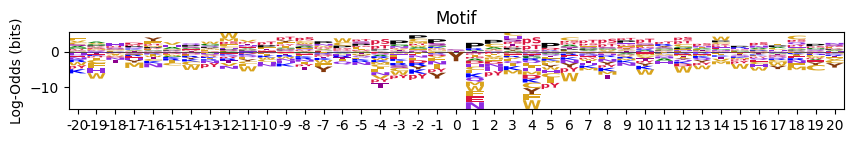

In [ ]:
pssm_LO = get_pssm_LO(pssm_df,'STY')
plot_logo_LO(pssm_LO,scale_zero=False,scale_pos_neg=False)

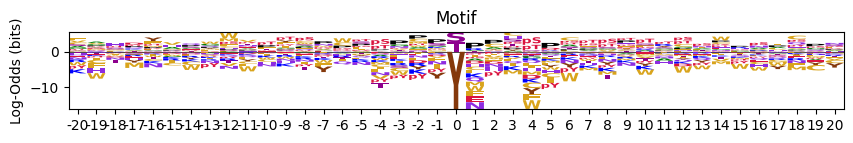

In [ ]:
# with zero position scaled to the max
plot_logo_LO(pssm_LO,scale_zero=True,scale_pos_neg=False)

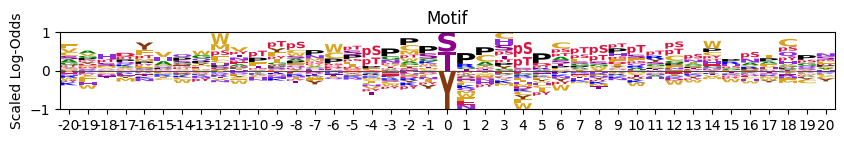

In [ ]:
# scaled positive and negative values for better visualization
plot_logo_LO(pssm_LO,scale_zero=True,scale_pos_neg=True)

In [ ]:
# # for those specific site type (S,T or Y), show acceptor in the middle instead of empty
# pssm_LO = get_pssm_LO(pssm_y,'Y')
# plot_logo_LO(pssm_LO,acceptor='Y')

In [ ]:
plt.close('all')

In [ ]:
#| export
def plot_logo_heatmap_LO(pssm_LO, # pssm of log-odds
                             title='Motif',
                         acceptor=None,
                             figsize=(17,10),
                             include_zero=False,
                         scale_pos_neg=True
                      ):
    
    """Plot logo and heatmap of enrichment bits vertically"""
    
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 5], width_ratios=[4, 1], hspace=0.11, wspace=0)

    ax_logo = fig.add_subplot(gs[0, 0])
    plot_logo_LO(pssm_LO,acceptor=acceptor,ax=ax_logo,title=title)

    ax_heatmap = fig.add_subplot(gs[1, :])
    plot_heatmap(pssm_LO,ax=ax_heatmap,position_label=False,include_zero=include_zero,scale_pos_neg=scale_pos_neg,colorbar_title='bits')

In [ ]:
# plot_logo_heatmap_LO(pssm_LO,acceptor='Y')

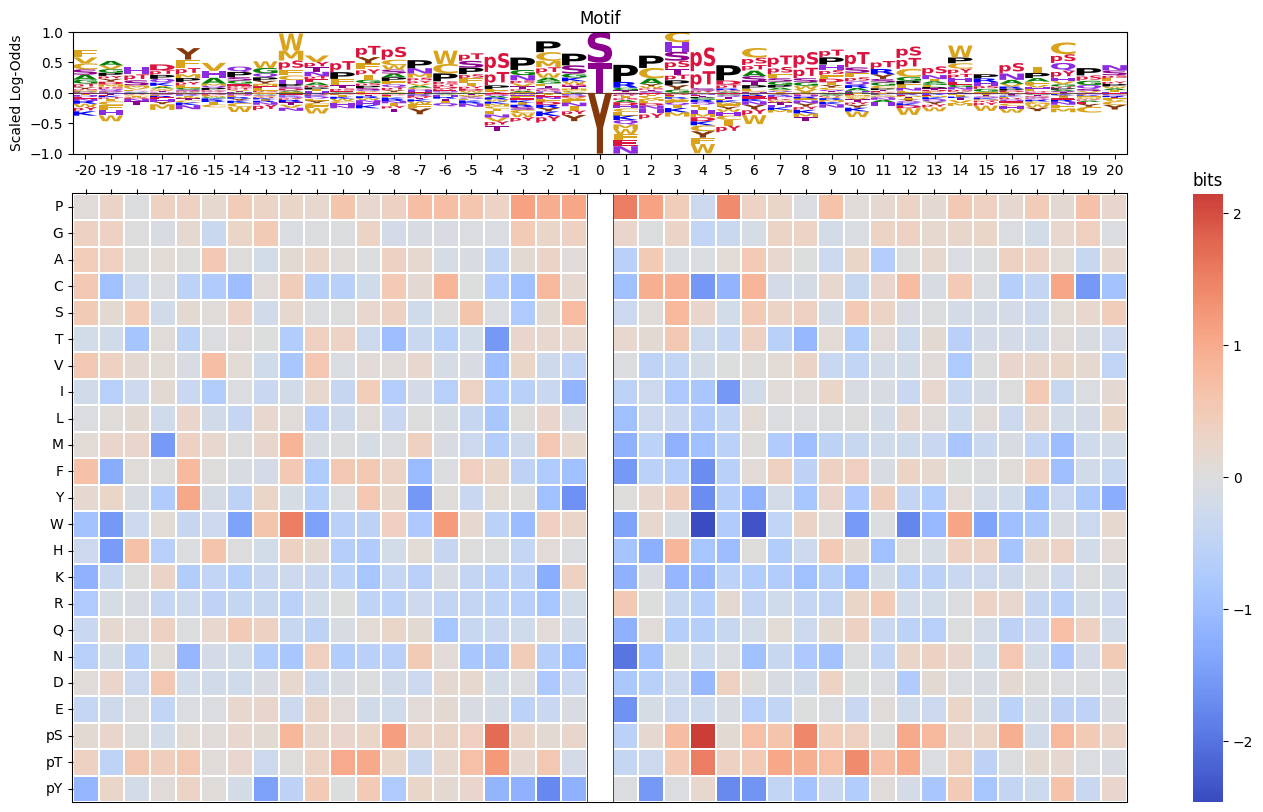

In [ ]:
pssm_LO = get_pssm_LO(pssm_df,'STY')
plot_logo_heatmap_LO(pssm_LO,scale_pos_neg=False) # normal color scale

In [ ]:
plt.close('all')

## Export -

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()